In [ ]:
%pip install --upgrade --quiet  praw pypdf

## Goal

We'll build a research assistant that combines 3 themes. As an example, we'll apply these to the [llama3.1 paper](https://ai.meta.com/blog/meta-llama-3-1/).

### Themes

1) `Report Generation` -- [Reports provide greater value than question-answering tools used in many RAG systems](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/). This is because reports offer more than just answers; they are tools for decision-making and resource allocation. Reports can save substantial costs by replacing the need for multiple employees or expensive processes.

2) `Automating multi-step workflows` -- There are some interesting examples of AI-mediated workflows that replace conventional investment dilligence. For example, [deal flow automation for VCs](https://x.com/MaxBrodeurUrbas/status/1806380947606253960) that analyzes pitch decks (e.g., extracts all metrics, finds founder LinkedIns + extracts their background, writes to Notion).

3) `Multi-perspective AI assistants` -- A generally powerful approach, as seen in papers like [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb), is to create AI assistants that take on various roles and have them simultanously inique about a topic.

### Approach

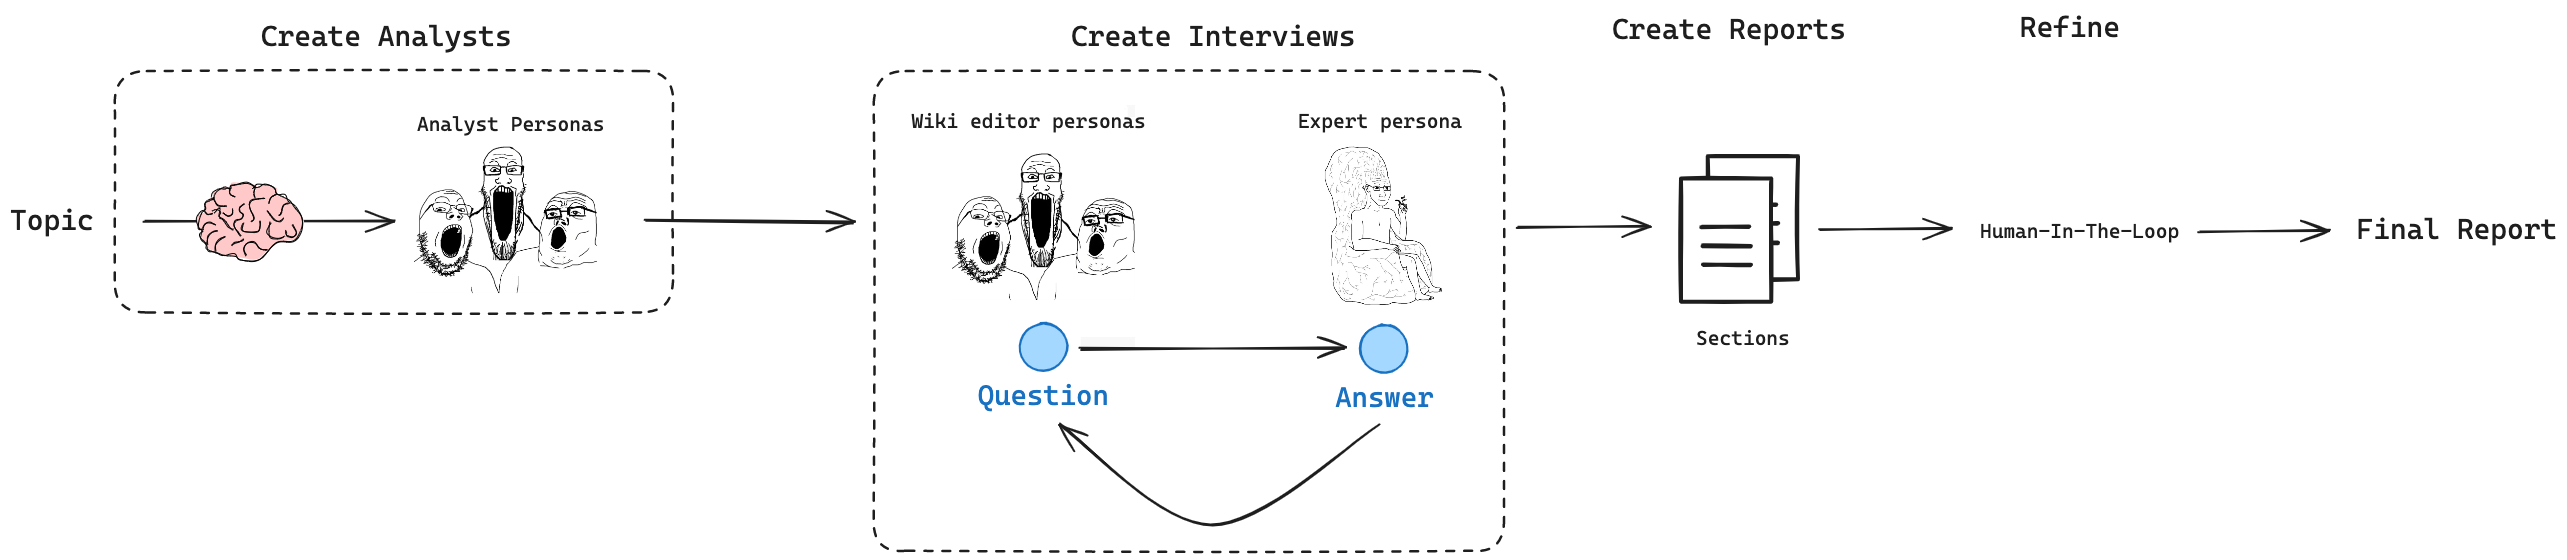

### Specify Topic and Content

Select the topic 

In [176]:
# Overall topic
topic = "Open source LLM investment themes based upon the Meta LLlama3.1 open source LLM"

#### Context for creating the analysts

Use Reddit comments about llama3.1 paper

In [ ]:
import praw

# URL of the Reddit post
url = 'https://www.reddit.com/r/LocalLLaMA/comments/1eabf4l/lets_discuss_llama31_paper_a_lot_of_details_on/'

# Replace the following values with your credentials
client_id = 'xxx'
client_secret = 'xxx'
user_agent = 'Local Llama Loader'

# Initialize the Reddit instance
reddit = praw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                     user_agent=user_agent)

# Fetch the submission
submission = reddit.submission(url=url)

# Load the comments
submission.comments.replace_more(limit=None)
comments = submission.comments.list()

# Concatenate comments into a single string
ANALYST_TOPIC_GENERATION_CONTEXT = "\n *** user commnent *** \n".join([comment.body for comment in comments])

Or use Mark Zuckerberg letter about llama3.1

In [309]:
from langchain_community.document_loaders import WebBaseLoader
url = "https://about.fb.com/news/2024/07/open-source-ai-is-the-path-forward/"
ANALYST_TOPIC_GENERATION_CONTEXT = WebBaseLoader(url).load()

#### Context for your expert 

Use full llama3.1 paper (higher token usage)

In [ ]:
# Full llama3.1 paper
from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader("/Users/rlm/Desktop/llama3_1.pdf")
pages = loader.load_and_split()
EXPERT_CONTEXT = "\n *** *** *** \n".join([page.page_content for page in pages])

Or, use full llama3.1 blog post (lower token usage)

In [310]:
# llama3.1 technical blog post
url = "https://ai.meta.com/blog/meta-llama-3-1/"
EXPERT_CONTEXT = WebBaseLoader(url).load() 

### Create Interviews

#### State

In [311]:
from typing import List, Optional
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the investment analyst.",
    )
    name: str = Field(
        description="Name of the investment analyst.", pattern=r"^[a-zA-Z0-9_-]{1,64}$"
    )
    role: str = Field(
        description="Role of the investment analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the investment analyst focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of investment analysts with their roles and affiliations.",
    )

class Section(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    context: str = Field(..., title="Provide a clear summary of the focus area that you researched.")
    findings: str = Field(..., title="Give a clear and detailed overview of your findings based upon the expert interview.")
    thesis: str = Field(..., title="Give a clear and specific investment thesis based upon these findings.")

class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    analyst: Analyst
    section: Section

class ResearchGraphState(TypedDict):
    analysts: List[Analyst]
    topic: str
    max_analysts: int
    sections: List[Section]
    interview_results: List[InterviewState]

#### LLM

In [ ]:
# Overall LLM
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

#### Analysts

Create analysts based upon the `ANALYST_TOPIC_GENERATION_CONTEXT`.

In [316]:
gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """
            You are tasked with creating a set of AI investment analyst personas based on source documents. 

            The overall sope of the research is: {topic}
            
            These analysts will be responsible for researching different investment themes identified in the documents. 
            
            Your goal is to ensure that the analysts capture interesting and diverse investment themes based on the provided information.

            First, carefully read and analyze the following source documents:
            
            {documents}
            
            After analyzing the documents, follow these steps:
            
            1. Identify key investment themes: Examine the source documents and extract the most prominent and interesting investment themes discussed. These themes should be diverse and cover different aspects of the investment landscape mentioned in the documents.
            
            2. Create AI analyst personas: Based on the identified themes, create a set of AI investment analyst personas. Each analyst should represent a different investment theme or area of focus related to the topics in the source documents.
            
            3. Assign focus areas: For each AI analyst, provide a brief description of their specific area of focus and expertise. Ensure that the focus areas are non-overlapping but collectively comprehensive, covering the main themes from the source documents.
            
            4. Limit the number of analysts: Create no more than {max_analysts} different analyst personas.

            """,
            
        ),
            ("user", "Topic of focus: {topic}"),
        ]
)

@as_runnable
async def generate_analysts(state: ResearchGraphState):
    """ Node to generate analysts """

    topic = state["topic"]
    max_analysts = state["max_analysts"]

    gen_perspectives_chain = gen_perspectives_prompt | llm.with_structured_output(Perspectives)
    perspectives = gen_perspectives_chain.invoke({"documents": ANALYST_TOPIC_GENERATION_CONTEXT, 
                                                  "topic": topic, 
                                                  "max_analysts": max_analysts})
    return {"analysts": perspectives.analysts}


initial_state = {"topic": topic, 
                 "max_analysts": 6}

perspectives = await generate_analysts.ainvoke(initial_state)

In [318]:
perspectives["analysts"][0]

Analyst(affiliation='Meta', name='Alice_OpenSource', role='Open Source Advocate', description='Alice focuses on the benefits and advancements of open source AI models, particularly the Llama 3.1 series. She emphasizes the importance of modifiability, cost efficiency, and the broader ecosystem that supports open source development. Alice is concerned with ensuring that AI technology remains accessible and secure for developers and organizations.')

### Ask Question

Use analyst to ask questions

In [322]:
from langchain_core.runnables import chain as as_runnable
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from langchain_core.prompts import MessagesPlaceholder
 
gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """You are an experienced investment analyst tasked with interviewing an expert to perform due diligence on a specific topic. 
            
            Your goal is to use this information to build an investment thesis given this topic and set of goals: {persona}
            
            Begin by introducing yourself using a name that fits your persona. 
            
            Stay true to your specific perspective throughout the conversation. 
            
            When interviewing the expert, follow this strategy:
            1. Start with broad, open-ended questions to clarify your understanding of the topic.
            2. As you gain more information, narrow your questions to drill deeper into specific aspects that are relevant to your investment thesis.
            3. Pay close attention to the expert's responses and look for opportunities to explore promising angles or address potential concerns.

            Here's how to analyze the expert's responses as the conversation proceeds:
            1. Carefully read and consider the information provided by the expert.
            2. Identify key points, trends, or insights that could be relevant to your investment thesis.
            3. Note any areas where you need more clarification or additional information.

            Based on your analysis, formulate follow-up questions that will help you gather more specific and relevant information. Your questions should:
            - Address any gaps in your understanding
            - Explore potential risks or opportunities
            - Seek quantitative data or specific examples to support claims
            - Probe into the expert's confidence level and the basis for their opinions

            Remember, your ultimate goal is to build an investment thesis on your topic. 

            When you are satisfied, complete the interview with: "Thank you so much for your help!"

            Remember to stay in character throughout your response, reflecting the persona and research goals provided to you.
            
            """,
        
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

@as_runnable
async def generate_question(state: InterviewState):
    """ Node to generate a question """

    analyst = state["analyst"]
    messages = state["messages"]
    
    gen_question_chain = gen_qn_prompt.partial(persona=analyst.persona) | llm   
    result = gen_question_chain.invoke({"messages": messages})
    return {"messages": [result]}

# Test
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
i = 0 # editor to test 
interview_state = {"analyst": perspectives["analysts"][i], "messages": messages}
question = await generate_question.ainvoke(interview_state)
messages.extend(question['messages'])

In [323]:
messages

[HumanMessage(content='So you said you were writing an article on Open source LLM investment themes based upon the Meta LLlama3.1 open source LLM?'),
 AIMessage(content="Hello Alice, my name is Jordan, and I'm an investment analyst focusing on emerging technologies. I'm particularly interested in the open-source AI landscape and how it can shape future investment opportunities. Given your expertise with the Llama 3.1 series and your role as an Open Source Advocate at Meta, I believe you can provide valuable insights into this area.\n\nTo start, could you give me an overview of the Llama 3.1 series and its key features? Specifically, what sets it apart from other AI models in the market?", response_metadata={'token_usage': {'completion_tokens': 107, 'prompt_tokens': 469, 'total_tokens': 576}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_4e2b2da518', 'finish_reason': 'stop', 'logprobs': None}, id='run-004be7a6-b18a-4216-bc16-200681653316-0', usage_metadata={'input_tokens'

### Create Expert

Node for answering questions posed by any editor using `EXPERT_CONTEXT`

In [324]:
# Expert RAG prompt 
gen_expert_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """You are an expert on the topic of {{topic}}.
            
            You are being interviewed by an investment analyst who is building an investment thesis about this topic. 
            
            Your goal is to provide clear, concise, and insightful answers to their questions using the information provided in the context.

            Here is the context you should use to inform your answers:
            {context}

            When answering questions, follow these guidelines:
            
            1. Use only the information provided in the context above. Do not introduce external information or make assumptions beyond what is explicitly stated.
            
            2. Structure your answers in a clear and organized manner. Use bullet points or numbered lists when appropriate to break down complex ideas.
            
            3. Be succinct and to the point. Avoid unnecessary elaboration or tangents.
            
            4. If a question cannot be answered based on the given context, state that you don't have enough information to provide a complete answer.
            
            5. Highlight key points that could be relevant to an investment thesis.
            
            Remember that your goal is to help the interviewer build towards an investment thesis.""",
            
        ),
        
            MessagesPlaceholder(variable_name="messages", optional=True),
        ]
)

@as_runnable
async def generate_answer(state: InterviewState):
    """ Node to answer """

    # Get state
    messages = state["messages"]
    
    # Answer question
    answer_chain = gen_expert_prompt | llm
    answer = answer_chain.invoke({'messages': messages,
                                  'topic': topic,
                                  'context': EXPERT_CONTEXT})  
    # Name the message
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

# Test
interview_state = {"analyst": perspectives["analysts"][i], "messages": messages}
answer = await generate_answer.ainvoke(interview_state)
messages.extend(answer['messages'])

In [325]:
messages

[HumanMessage(content='So you said you were writing an article on Open source LLM investment themes based upon the Meta LLlama3.1 open source LLM?'),
 AIMessage(content="Hello Alice, my name is Jordan, and I'm an investment analyst focusing on emerging technologies. I'm particularly interested in the open-source AI landscape and how it can shape future investment opportunities. Given your expertise with the Llama 3.1 series and your role as an Open Source Advocate at Meta, I believe you can provide valuable insights into this area.\n\nTo start, could you give me an overview of the Llama 3.1 series and its key features? Specifically, what sets it apart from other AI models in the market?", response_metadata={'token_usage': {'completion_tokens': 107, 'prompt_tokens': 469, 'total_tokens': 576}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_4e2b2da518', 'finish_reason': 'stop', 'logprobs': None}, id='run-004be7a6-b18a-4216-bc16-200681653316-0', usage_metadata={'input_tokens'

### Interview between expert and analyst

Combine the above into an interview graph

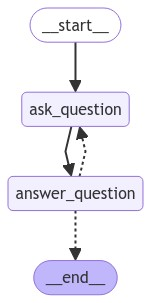

In [355]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# Max turns
max_num_turns = 3

# Conditional edge
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    # Get messages
    messages = state["messages"]

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return END

    # This router is perform after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help!" in last_question.content:
        return END
    return "ask_question"

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_edge(START, "ask_question")
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_conditional_edges("answer_question", route_messages)
interview_builder.add_edge("ask_question", "answer_question")

# Set up memory
memory = MemorySaver()

# Interview 
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [327]:
# Test
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
i = 0 # editor to test 
interview_state = {"analyst": perspectives["analysts"][i], "messages": messages}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run
interview = await interview_graph.ainvoke(interview_state, thread)

We can get the state for the full interview.

In [328]:
full_interview_state = interview_graph.get_state(thread).values["messages"]

And we can look at specific messages.

In [330]:
full_interview_state[-1].content[0:250]

'Certainly, Jordan. Here are some specific examples and case studies where the Llama 3.1 series has been successfully implemented, demonstrating its benefits in real-world applications:\n\n### Case Studies and Examples\n\n1. **AI Study Buddy in WhatsApp a'

### Section writing

Write a section of the report

In [331]:
section_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """You are an investment analysis. Your persona as an investment analyst is defined as follows: {persona}

            You conduced an interview with an expert on this topic, as shown in the below messages.

            Here is your task:
            
            1. Analyze the interview content thoroughly, paying special attention to insights relevant to your specific focus as an investment analyst.
            
            2. Write a comprehensive section based on your analysis. Structure your output as a markdown document with the following sections:

               a. Overview
               b. Key Insights
               c. Investment Thesis

            3. Begin with a clear and concise overview of the main learnings from the interview.

            4. In the "Key Insights" section, highlight the most important points from the interview that are relevant to your investment focus.

            5. Build towards your ultimate goal of creating an investment thesis in the final section. This should synthesize the information from previous sections and present a clear, well-reasoned investment recommendation or strategy.

            Use proper markdown formatting throughout your document. Use headers (##, ###, etc.) to separate sections, bullet points or numbered lists where appropriate, and emphasis (bold or italic) for key points.

            Maintain a professional tone throughout the document, balancing analytical insights with clear, accessible language.

            Ensure that your analysis and recommendations are closely tied to the specific focus of your investment analyst persona.

            If there are any areas where the interview content is unclear or insufficient to make a strong recommendation, note this in your analysis.

            Remember, your primary goal is to provide a well-structured, insightful analysis that culminates in a strong investment thesis based on the interview content and your specific area of focus as an investment analyst.""",
        
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

@as_runnable
async def generate_section(state: InterviewState):
    """ Node to generate a question """

    # State 
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate section
    section_gen_chain = section_gen_prompt.partial(persona=analyst.persona) | llm
    section = section_gen_chain.invoke({"messages": messages})
    
    return {"section": section}

# Test
section_state= {"analyst": perspectives["analysts"][i], "messages": interview['messages']}
section = await generate_section.ainvoke(section_state)

In [332]:
from IPython.display import Markdown
Markdown(section['section'].content.replace("\n#", "\n##"))

Thank you, Alice. This information is incredibly valuable. Based on our discussion, I will now compile a comprehensive analysis and investment thesis. Here is the markdown document:

---

### Overview

The Llama 3.1 series, developed by Meta, represents a significant advancement in the open-source AI landscape. With features such as extended context length, multilingual support, and advanced capabilities like synthetic data generation and model distillation, Llama 3.1 stands out as a highly customizable and cost-efficient option for developers. This document analyzes the key insights from an expert interview and builds an investment thesis around the Llama 3.1 series.

### Key Insights

#### Enhanced Modifiability and Customization

- **Open Access to Model Weights**: Developers can download and fully customize the model weights, allowing for specific fine-tuning and training on new datasets.
- **Extended Context Length**: The 128K context window supports complex and lengthy interactions, making it suitable for advanced use cases.
- **Multilingual Support**: Supports eight languages, enhancing global usability and enabling the development of multilingual applications.
- **Synthetic Data Generation**: Facilitates the creation of high-quality synthetic data for training and improving smaller models.
- **Model Distillation**: Achieved at an unprecedented scale in open source, allowing for the creation of smaller, more efficient models.
- **Tool Integration**: Includes built-in security and safety tools like Llama Guard 3 and Prompt Guard, and standardized APIs for easier integration.

#### Strong Ecosystem and Partnerships

- **Ecosystem Support**: Over 25 partners, including AWS, NVIDIA, Databricks, and Google Cloud, offer services and optimizations for Llama 3.1.
- **Cost Efficiency**: Offers some of the lowest cost per token in the industry, making it a cost-effective option for developers.

#### Real-World Applications

- **AI Study Buddy**: Deployed in WhatsApp and Messenger, providing personalized learning assistance to students.
- **Medical Field Application**: Tailored to guide clinical decision-making, enhancing healthcare delivery.
- **Healthcare Non-Profit Startup in Brazil**: Organizes and communicates patient information securely and efficiently.

### Investment Thesis

#### Proven Real-World Applications

The successful implementations of Llama 3.1 in education and healthcare demonstrate its practical benefits and versatility. These case studies highlight the model's ability to provide personalized assistance, improve decision-making, and enhance operational efficiency.

#### Customization and Flexibility

Llama 3.1's open access to model weights, extended context length, and multilingual support make it highly adaptable to various industries and applications. The advanced capabilities for synthetic data generation and model distillation further enhance its customization potential.

#### Strong Ecosystem and Cost Efficiency

The robust ecosystem support from major partners and the integrated tools for security and safety enhance the model's deployment potential. Additionally, the lower cost per token makes Llama 3.1 an attractive option for a broad range of developers and businesses, driving widespread adoption.

#### Investment Recommendation

Given the proven real-world applications, enhanced customization and flexibility, strong ecosystem support, and cost efficiency, investing in the Llama 3.1 series presents a compelling opportunity. The model's versatility and advanced capabilities position it well to drive innovation and new business models across various industries. Therefore, I recommend a strategic investment in the Llama 3.1 series to capitalize on its potential for widespread adoption and impact.

---

I hope this comprehensive analysis and investment thesis align with your expectations. Let me know if there are any areas you would like to explore further or if additional information is needed.

## End to End Analyst

Now, we parallelize this across all set of analysts

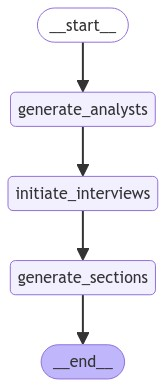

In [338]:
@as_runnable
async def initiate_interviews(state: ResearchGraphState):
    """ Node to generate interviews in batch """

    # States 
    initial_states = [
    {
        "analyst": analyst,
        "messages": [
            HumanMessage(
                content=f"So you said you were writing an article on {topic}?"
            )
        ],
    } for analyst in state["analysts"]]

    # Batch the interviews
    interview_results = await interview_graph.abatch(initial_states)
    return {"interview_results": interview_results}

@as_runnable
async def generate_sections(state: ResearchGraphState):
    """ Node to generate sections in batch """

    # States 
    initial_states = [
    {
        "analyst": analyst,
        "messages": interview_result['messages'],
    }
    for analyst,interview_result in zip(state["analysts"],state["interview_results"])]

    # Batch the sections
    sections = await generate_section.abatch(initial_states)    
    return {"sections": sections}

builder = StateGraph(ResearchGraphState)
builder.add_node("generate_analysts", generate_analysts)
builder.add_node("initiate_interviews", initiate_interviews)
builder.add_node("generate_sections", generate_sections)

builder.add_edge(START, "generate_analysts")
builder.add_edge("generate_analysts", "initiate_interviews")
builder.add_edge("initiate_interviews", "generate_sections")
builder.add_edge("generate_sections", END)

graph = builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [339]:
# Thread
thread = {"configurable": {"thread_id": "1"}}

# State 
initial_state = {"topic" : topic, "max_analysts" : 6}

# Run
research_results = await graph.ainvoke(initial_state, thread)

In [353]:
from IPython.display import Markdown
Markdown(research_results['sections'][4]['section'].content.replace("\n#", "\n##"))

Thank you, Eve. This information is incredibly valuable. Based on our discussion, I will now proceed to draft a comprehensive analysis and investment thesis. Here is the structured markdown document:

---

### Overview

The interview with Eve_Safety, an AI Safety Specialist at Meta, provided deep insights into the safety and ethical considerations surrounding the development and deployment of Meta's Llama 3.1 open-source AI model. Key areas of focus included the rigorous safety measures, community engagement, and the model's competitive performance in real-world scenarios. These insights are crucial for understanding the investment potential in the AI space, particularly concerning open-source models like Llama 3.1.

### Key Insights

#### Safety Tools and Measures
- **Llama Guard 3**: A multilingual safety model designed to ensure responsible use.
- **Prompt Guard**: A prompt injection filter to prevent misuse of the model.
- **Red Teaming**: Extensive exercises involving internal and external experts to identify and mitigate risks such as prompt injection attacks and biases.
- **Supervised Fine-Tuning (SFT)**: Multiple rounds to improve the model's helpfulness, quality, and instruction-following capabilities.
- **Rejection Sampling (RS) and Direct Preference Optimization (DPO)**: Techniques to refine the model's responses and ensure high-quality outputs.

#### Community and Ecosystem Engagement
- **Open Source Components**: Providing sample applications and components to set a standard for responsible use.
- **Llama Stack**: Engaging with the community to create standardized interfaces for building toolchain components and agentic applications.
- **Licensing Terms**: Including guidelines and restrictions to ensure ethical use.
- **Monitoring and Feedback**: Active community monitoring and feedback mechanisms to address misuse.

#### Performance in Real-World Scenarios
- **Benchmark Scores**: Competitive performance on over 150 benchmark datasets, particularly in multilingual translation and long-context understanding.
- **Human Evaluation**: Superior performance in tasks requiring long-context understanding and tool use.
- **Market Applications**: Promising applications in healthcare, education, and enterprise solutions.

#### Market Potential
- **Healthcare**: AI assistants for clinical decision-making and patient information management.
- **Education**: AI study buddies deployed in WhatsApp and Messenger.
- **Enterprise Solutions**: Document management and customer support applications.

### Investment Thesis

#### Synthesis of Insights
Meta's Llama 3.1 represents a significant advancement in the open-source AI model landscape, combining robust safety measures, community engagement, and competitive performance. The extensive red teaming process and tools like Llama Guard 3 and Prompt Guard ensure that the model is both safe and ethical to use. The community and ecosystem engagement strategies further enhance the model's responsible deployment and continuous improvement.

#### Investment Recommendation
Given the comprehensive safety measures, strong community engagement, and competitive performance metrics, investing in technologies and companies that leverage Llama 3.1 presents a promising opportunity. The model's applications in healthcare, education, and enterprise solutions demonstrate its versatility and market potential. Early adopters and success stories, such as the healthcare startup in Brazil and the AI study buddy, further validate its practical utility and market readiness.

#### Strategy
- **Focus on Healthcare and Education**: Invest in startups and companies that are developing AI solutions in these sectors, leveraging Llama 3.1's capabilities.
- **Support Open-Source Initiatives**: Encourage and invest in open-source projects that align with Meta's safety and ethical standards, ensuring responsible AI development.
- **Monitor Community Engagement**: Keep an eye on community feedback and developments to identify emerging opportunities and potential risks.

In conclusion, Meta's Llama 3.1 offers a robust, ethical, and high-performing AI model that is well-positioned for significant impact across various industries. Investing in this space aligns with both financial and ethical considerations, making it a compelling opportunity for forward-thinking investors.

---

Would you like to add or modify any part of this analysis?

## TODO

1/ `Map-Reduce` rather than `abatch`?

2/ `Sub-graph` for the `interview_graph`?

3/ HIL step to supplement the sections w/ web-research.

4/ `Reduce` phase to distill down into a single, final report. 